### Grammar learning in children

This notebook simulates data for a study on learning artificial grammar in children.

Study design: Daniela Schönberger
Modelling: Clara Kuper

*Children are presented with a sequence of elements (colours, animals, fruits) that follow a defined gramatical structure. The grammar is defined in Schiff and Katan (2014), Fig 1C; and in Reber (1967). After learning by passivly watching grammatical sequences participants make a forced choice between two sequences, which of the presented sequences is grammatically valid. If the responses are repeatedly correct, the sequence is elongated resulting in a harder discrimination. If responses are repeatedly incorrect, the sequence is shortened.*
 
###########

*Difficulty levels* 
4 levels: 
1 = sequences with 3-4 items 
2 = sequences with 4-5 items 
3 = sequences with 5-6 items 
4 = sequences with 6-7 items

*Adaptation rule*
0-1 trial correct: easier
2-3 trials correct: same
4-5 trials correct: harder

###########

#### Open Question:

How can we develop a score for the responses that captures the differences in difficulty over different levels?
(3 responses correct in level 2 are 'better' than 3 responses correct in level 1)

Problems: levels overlap (length 4 appears in level 1 an level 2)

*Adaptive scores (ideas)*

*Idea 1*
score = level - wrong answers/trials
summed up / averaged for one session

*Idea 2*
score = sum over length of "correctly answered" trains

*Idea 3*
comupte difficulty of grammar with n elements

score = sum over difficulty of "correctly answered" trains


In [27]:
# Libraries needed

import random as rd
import matplotlib.pyplot as plt
import math as m
import pandas as pd

ModuleNotFoundError: No module named 'plotly'

In [2]:
# Define levels
levels = [1,2,3,4]

# Define experiement blocks and trials
nblock = 6
ntrial = 5

In [3]:
# a decimal range function
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

In [41]:
# a logistic response function from 1 to 0

def resp_psychometric(x,k,x0): 
    '''
    This function returns the probability for a correct response as a logistic response function. \
    It depends on the parameters: \nx = input value \nk = slope \nx0 = midpoint
    '''
    fx = 1-(1/(1+(m.e**(-k*(x-x0)))))
    fx = 0.5 + 0.5*fx
    return fx

# a list to nicely plot the function with continuous input values

def make_list(start,stop,slope,reflect):
    psych_list    = []
    input_list    = []

    for v in frange(start,stop,0.1):
        psych = resp_psychometric(v,slope,reflect)
        psych_list = psych_list + [psych]
        input_list = input_list + [v]
    return psych_list, input_list

In [5]:
# function that decides if the level remains or not
def define_level(data,level):
    'depends on the cut-off-values that are being set here'
    if data >= 4:
        if level < 3:
            return level+1
        else: 
            return level
    if data <= 1:
        if level > 0:
            return level-1
        else:
            return level
    else:
        return level

In [6]:
# Load the ACS Reber score list

xls_file = pd.ExcelFile('AGL_Reber_ungram_Sequ_ACS.xlsx')
xls_file.sheet_names

ACS_R_table = xls_file.parse('Tabelle1')

# create lists for levels

ACS_R_list = []
for level in levels:
    level_R_data = ACS_R_table.query(f'Level == {float(level)}')
    level_R_list = level_R_data['Global ACS'].tolist()

    ACS_R_list = ACS_R_list + [level_R_list]
    

In [7]:
# Load the ACS Skosnik score list

xls_file = pd.ExcelFile('AGL_Skosnik_ungram_Sequ_ACS.xlsx')
xls_file.sheet_names

ACS_S_table = xls_file.parse('Tabelle1')

# create lists for levels

ACS_S_list = []
for level in levels:
    level_S_data = ACS_S_table.query(f'Level == {float(level)}')
    level_S_list = level_S_data['Global ACS'].tolist()

    ACS_S_list = ACS_S_list + [level_S_list]

In [8]:
# Define class kid
class Kid():
    # define attributes of the kid
    'a class that holds the properties name, age and response parameters \
    psych_curve and psych_reflect. \
    Learning parameters set the logistic response function and should be modulated with learning \
    Suggested range for psych_curve: > 0 to 10  \
    Suggested range for psych_reflection: >= shortest element, <= than longest element'
   
    def __init__(self, name, age, psych_curve, psych_reflect):
        self.name          = name
        self.age           = age
        self.psych_curve   = psych_curve
        self.psych_reflect = psych_reflect

    # define testing
    def test_block(self, level_test, n_trial):
        
        # reset the number of correct responses in block
        change_level = 0
        
        # empty data frame to be filled
        data = pd.DataFrame('NA', index=range(ntrial), columns=['trial','response', 'score', 'level', 'block'])
        
        # loop through trials
        for trial in range(n_trial):
            
            # what is the ACS score of the sequence presented
            score = rd.sample(level_test,1)[0]
            
            # how difficult is the response based on the score
            prob_correct  = resp_psychometric(score,self.psych_curve,self.psych_reflect)
            
            # get correct (1)/incorrect (0) answer
            answer = rd.choices(population=[1,0],weights=[prob_correct,1-prob_correct],k=1)
            
            # sum over block
            change_level = change_level+answer[0]
            
            # save to output
            data.iloc[trial]['trial']      = trial
            data.iloc[trial]['response']   = answer[0]
            data.iloc[trial]['score']      = score 
        
        return change_level, data

In [9]:
# Define experiement
def run_experiment(nblock, ntrial, kid, grammar):

    # Start at level one
    level = 0
    
    # Empty data frame
    raw_data = pd.DataFrame('NA', index=[], columns=['trial', 'response', 'score', 'level', 'block'])
    
    # Loop through blocks
    for block in range(nblock):
        
        # each block returns response data and a new level
        change_level, new_data = kid.test_block(grammar[level],ntrial)
        
        # save number of the block to output
        new_data['block'] = block
        new_data['level'] = level
        raw_data   = pd.concat([raw_data, new_data])
        
        # new level for next block
        level = define_level(change_level,level)
    
    # return output         
    return raw_data

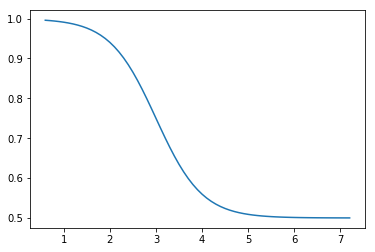

In [43]:
# Experiment setup
# Define the parameters for the participant:

slope_of_function   = 2   # "0" flat line, 0 - 1 approx. linear, 
                          # higher values reflect steeper switch between 0 and 1
                          # negative values reverse response
point_of_reflection = 3.0   # 75% correct responses at this score
min_score           = 0.6   # the shortest sequence is that long
max_score           = 7.2   # the longest sequence is that long

# show the responses for better overview
simulated_list, input_list = make_list(min_score,max_score,slope_of_function,point_of_reflection)
plt.plot(input_list,simulated_list);
plt.show()   # don't be confused by the x-axis, the numbers reflect instances of numbers 
             # drawn between min_score and max_score with 0.1 steps

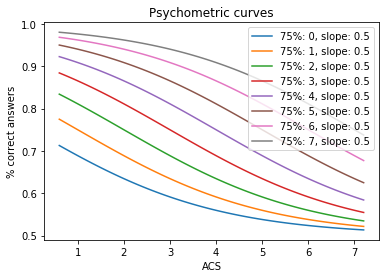

In [56]:
# Simulate a shift in reflection point

min_score           = 0.6   # the shortest sequence is that long
max_score           = 7.2   # the longest sequence is that long

# Make several of these:
for slope in [0.5]:
    for point in range(0,8):
        simulated_list, input_list = make_list(min_score,max_score,slope,point)
        plt.plot(input_list,simulated_list,label = f'75%: {point}, slope: {slope}');

plt.xlabel('ACS')
plt.ylabel('% correct answers')

plt.title("Psychometric curves")

plt.legend()
plt.savefig('psychometric curves2',transparent = True, dpi = 400) 

In [11]:
# define participant
Lucy = Kid('Lucy', 9, slope_of_function, point_of_reflection)

# run experiment
data = run_experiment(nblock,ntrial,Lucy,ACS_S_list)

# show simulated raw data
print(data)


  trial response     score level block
0     0        1  0.666667     0     0
1     1        1  0.666667     0     0
2     2        1  0.666667     0     0
3     3        1       0.5     0     0
4     4        1         1     0     0
0     0        1      1.25     1     1
1     1        1   1.33333     1     1
2     2        1       1.5     1     1
3     3        1         1     1     1
4     4        1      1.25     1     1
0     0        1         2     2     2
1     1        1         2     2     2
2     2        0      2.25     2     2
3     3        1      2.25     2     2
4     4        1         2     2     2
0     0        1   3.56667     3     3
1     1        1      3.45     3     3
2     2        1   3.43333     3     3
3     3        1      3.45     3     3
4     4        0   3.43333     3     3
0     0        1      3.55     3     4
1     1        0       3.5     3     4
2     2        1       3.5     3     4
3     3        1      3.45     3     4
4     4        1   3.4333

In [12]:
# Performance score

# Score idea 1:
def score1(data):
    'returns a score computed by the difference in an assigned level and the proportion of wrong answers/block \
    data   = panda data frame'
    
    # compute level for each block
    full_score = 0
    for b in range(max(data['block'])+1):
        block_data = data.query(f'block == {b}')
        level      = block_data['level'][0]+1
        score      = level - ((ntrial - sum(block_data['response']))/ntrial)
        full_score = full_score + score

    exp_score = full_score/nblock
    
    return exp_score
    
# Score idea 2:

def score2(data):
    'returns the sum of correctly solved elements'
    elements_correct = data['response']*data['score']
    sum_correct = sum(elements_correct)
    
    return sum_correct/(ntrial*nblock)

In [37]:
# Compare score1 and score2 for different reflection points x0

# shift x0 from 3 to 7, compute score1 and score2 and plot

# Simulate for x experiments
score_data = pd.DataFrame('NA', index=[], columns=['reflection_point', 'score1', 'score2'])
slope      = 2
repeats    = 20

for point in range(0,8):
    Baby = Kid('Baby',6, slope, point)
    point_data = pd.DataFrame('NA', index=range(repeats), columns=['reflection_point', 'score1', 'score2','grammar'])
    for grammar in [ACS_S_list,ACS_R_list]:
        if grammar == ACS_S_list:
            gr_id = 2
        else:
            gr_id = 1
        for participant in range(repeats):
            data = run_experiment(nblock,ntrial,Baby,grammar)

            s1   = score1(data)
            s2   = score2(data)

            point_data.iloc[participant]['reflection_point'] = point
            point_data.iloc[participant]['score1']  = s1
            point_data.iloc[participant]['score2']  = s2
            point_data.iloc[participant]['grammar'] = gr_id

        score_data = pd.concat([score_data,point_data]) 

score_data

,grammar,reflection_point,score1,score2
0,2,0,0.766667,0.383333
1,2,0,1.63333,0.881667
2,2,0,2.2,1.19167
3,2,0,0.8,0.55
4,2,0,1.4,0.647222
5,2,0,0.5,0.361111
6,2,0,1.76667,0.840556
7,2,0,1.96667,0.971111
8,2,0,0.566667,0.355556
9,2,0,0.5,0.361111


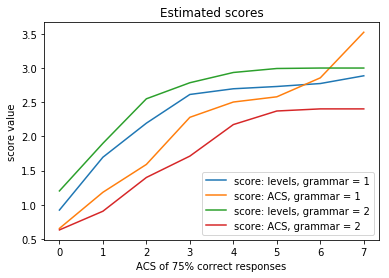

In [38]:
# Analyse output from simulated scores

# mean score for each reflection level

for grammar in [1,2]:
    analyse_scores = pd.DataFrame('NA', index=[], columns=['reflection_point', 'mean_score1', 'mean_score2'])
    grammar_data       = score_data.query(f'grammar == {grammar}')
    for point in range(0,8):
        mean_scores    = pd.DataFrame('NA', index=[0], columns=['reflection_point', 'mean_score1', 'mean_score2'])
        subset         = grammar_data.query(f'reflection_point == {point}')

        mean_scores.iloc[0]['reflection_point'] = point
        mean_scores.iloc[0]['mean_score1']      = sum(subset['score1'])/repeats
        mean_scores.iloc[0]['mean_score2']      = sum(subset['score2'])/repeats

        analyse_scores = pd.concat([analyse_scores,mean_scores])

    plt.plot(analyse_scores['reflection_point'],analyse_scores['mean_score1'],label = f'score: levels, grammar = {grammar}');
    plt.plot(analyse_scores['reflection_point'],analyse_scores['mean_score2'],label = f'score: ACS, grammar = {grammar}');

plt.xlabel('ACS of 75% correct responses')
plt.ylabel('score value')

plt.title("Estimated scores")

plt.legend()

plt.savefig('scores_estimate.png', dpi = 400, transparent = True )